<a href="https://colab.research.google.com/github/VictoriaOG1/Machine-Learning/blob/main/ExploringMNIST_Planteamiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Explorando MNIST y redes neuronales profundas

El propósito de este documento es ayudarlo a aprender sobre redes neuronales profundas y explorar cómo el cambio de la arquitectura de una red neuronal afecta el rendimiento de la red. 

Antes de poder construir redes neuronales, necesitamos importar algunas cosas de Keras y preparar nuestros datos. El siguiente código extrae el conjunto de datos MNIST, proporcionado por Keras, y corvierte las imágenes de 28x28 píxeles en un vector con una longitud 784. Además, modifica las etiquetas de un valor numérico 0-9 a un vector *one-hot encoded*.

*One-hot encoding* hace referencia a un grupo de bits entre los cuales las combinaciones validas de valores son solo aquellas con un solo bit alto (1) y todas las demás bajas (0).

<center><img src="https://i.imgur.com/wKtY1Og.png" alt="drawing" width="400"/>





In [ ]:
import tensorflow as tf
import keras
from keras.datasets import mnist
#from tensorflow.keras.utils import plot_model
from keras.utils.vis_utils import plot_model
from keras.layers import Dense #capas fully connected
from keras.models import Sequential
from matplotlib import pyplot as plt
from random import randint
import numpy as np

from keras.utils import to_categorical ##############################

print(tf. __version__)
# Preparar el conjunto de datos
# Configurar la división del entrenamiento y prueba
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Hacer una copia antes de convertir a 1D 
# esta copia se usa para mostrar las imágenes
x_train_drawing = x_train

image_size = 784 # 28 x 28
x_train = x_train.reshape(x_train.shape[0], image_size)  #vector de 784, flattening 
x_test = x_test.reshape(x_test.shape[0], image_size)

# Convierte vectores de clase en matrices de clases binarias (one-hot encoding)
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print(y_test)
print(x_train.shape) #m=num de ejemplos = 60 000, n=784 (features)
print(x_test.shape)

2.12.0
11490434/11490434 [==============================] - 0s 0us/step
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(60000, 784)
(10000, 784)


## Un vistazo a algunos dígitos al azar

Es bueno tener una idea del conjunto de datos con el que estamos trabajando. Ejecute este código varias veces para ver los nuevos dígitos seleccionados al azar del conjunto de entrenamiento. 

[5, 4, 3, 2]


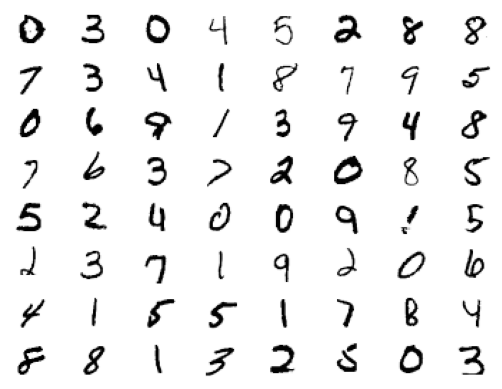

In [ ]:

#itereamos desde i=0 hasta 63. De manera general range(start, stop[, step])
print(list(range(5,1,-1)))
for i in range(64):
    ax = plt.subplot(8, 8, i+1)
    ax.axis('off')
    plt.imshow(x_train_drawing[randint(0, x_train.shape[0])], cmap='Greys')

## **0.1 Primera red (3 puntos)**

Aquí hay una primera red simple para resolver MNIST. Tiene una sola capa oculta con 32 nodos.  

1.   *La red tiene un total de 25450 parámetros entrenables. Demuestre cómo Keras calcula el número de parámetros entrenables en esta arquitectura*
2.   *Qué significa `None` en la forma de salida (output shape) que se muestra como `(None,32)`*?
3. *cuál es la función de activación softmax y su relación con la sigmoide?*

1. El caculo se deriva de calcular el número de parámetros que salen en cada capa. La fórmula se aplica: num_param_layer = num_input_param (with el BIAS) * num_output_param, total_param = sum(num_param_layer_i), siendo i el numero de layers que tenga la red. En este caso sería: num_param_hidden_layer = (784+1) * 32 = 25120, num_param_output_layer = (32+1)*1 = 330, total_param = 25120 + 330 = 25450
2. El None hace referencia a que no importa el tamaño del input que van a haber para la capa ya que la salida definida. En el caso de (None, 32), la entrada puede ser de tamaño 1000000 pero se reducen solo a 32 en ese hidden layer. Lo mismo pasa con (None, 10).
3. La función de activación softmax es la forma generalizada de la función sigmoide. Esta se usa para problemas multi-clase, en donde la salida da cada clase se encuentra en el rango de 0-1, y la suma de los valores de cada clase es 1. Se utiliza en los problemas de clasificación.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                25120     
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


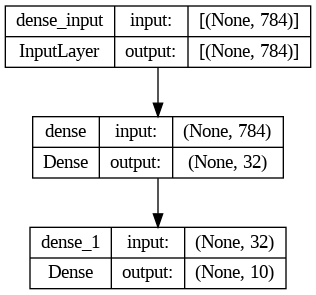

In [ ]:
model = Sequential()

# La capa de entrada requiere el parámetro especial input_shape que debe 
# coincidir con la forma de nuestros datos de entrenamiento.
model.add(Dense(units=32, activation='sigmoid', input_shape=(image_size,))) #Input and Hidden Layer
model.add(Dense(units=num_classes, activation='softmax')) #output Layer. Si num_classes = 2 (pos y neg): model.add(Dense(units=1, activation='sigmoid')) equivalente model.add(Dense(units=2, activation='softmax'))  
model.summary() # REPRESENTAR
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## **0.2 Entrenar y evaluar la red (7 puntos)**

Este código entrena y evalúa el modelo que definimos anteriormente. También usa `matplotlib` y el objeto `history` proporcionado por Keras, que rastrea cómo se comporta el modelo a través de su entrenamiento. Observe que usamos el objeto `history` para trazar la precisión del entrenamiento y la precisión de la validación a lo largo del tiempo (*epochs*).



1.   *En el siguiente código, la función de costo o pérdida (loss function) está definida como `'categorical_crossentropy'`. Consulte cuál es la forma matemática de esta función y explique sus parámetros.*
2.   *Cuál es la diferencia entra la función de costo de entropía cruzada (Cross-Entropy loss) con respecto a la función de costo definida para la regresión logística?*
3. *Consulte las diferencias entre minibatch gradient descent, batch gradient descent y Stochastic gradient descent.*
4. *Según lo consultado en el punto anterior, qué tipo de gradient descent (batch, minibatch o stochastic) describe la función de costo para la red neuronal estudiada en clase? Justifique su respuesta.*
5. *Explique qué significa una época en una red neuronal (epoch)*
6. *Explique qué es el tamaño del batch de una red neuronal.*
7. *Cuál es la diferencia entre tamaño del batch y época?*





1. 
##Ecuación Matemática##
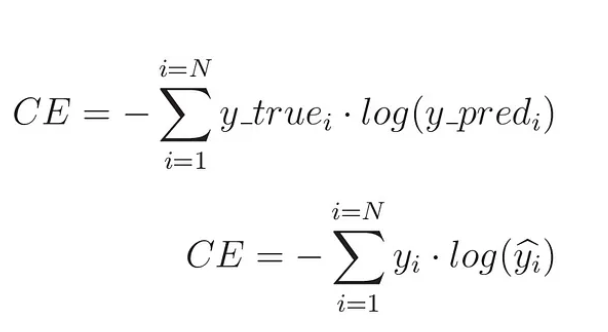


En donde y_true es el vector de valores verdaderos de los inputs hacia las clases en el output, y_pred es el vector de los valores de predicción de los inputs pasados correspondientes a cada y_true de las clases.

2.

###Cross Entropy loss###
- Función que se usa para los problemas de clasificación multiclase, ya que mide la diferencia entre la distribución de probabilidad predicha por el modelo y la distribución de probabilidad real de las etiquetas.
###Binary Entropy loss###
- Función que se usa en la regresión logística, es decir para la clasificación binaria, mide la diferencia entre las etiquetas reales y las predicciones realizadas.

3. 

###Batch Gradient###
- Todos los datos de entrenamiento son tomados en consideración para cada época. Se realiza el promedio de las gradientes de todos los parámetros de entrenamiento y esa gradiente media la usa para actualizar los parámetros.
###Mini Batch Gradient###
- Variante del descenso de gradiente el cual divide el dataset en subconjuntos de datos, en los cuales se calcula la gradiente con respecto a los parámetros del modelo. El tamaño de los lotes es el hyperparametro para el número de ejemplos de entrenamiento que estarán en los mini-batchs. Su convergencia es más rápida que el Batch Gradient.
###Stochastic Gradient###
- Este algoritmo usa ejemplo a la vez de todo el dataset para el calculo de la gradiente. Selecciona aleatoriamente el ejmemplo para el entrenamiento. Se usa cuando el dataset es demasiado grande y evita los mínimos locales. Sin embargo, requiere de más iteraciones para converger debido a la naturaleza para el calculo del descenso de gradiente.


4. Con lo visto anteriormente, El modelo define el batch size, es decir que define el tamaño del lote que se va a analizar en cada época, por lo que usa el Mini-Batch Gradient Descent.

5. Una época es una iteración sobre el conjunto de entrenamiento, el cual se le presenta a la red neuronal y le permite actualizar los pesos de los parámetros del entrenamiento. 

6. Es el número de ejemplos que se usan en cada iteración de entrenamiento, este afecta la velocidad y calidad de entrenamiento. Mientras más grande, mejor el entrenamiento con respecto a calidad, pero conlleva una convergencia más lenta.

7. El tamaño batch solo hace refencia a cuantos ejemplos se van a utilizar duante cada iteración. Por otro lados, la época corresponde a dicha interación que realiza el entrenamiento. Se puede decir que el batch size define el número de pasos que se van a hacer en una época.

Epoch 1/200
422/422 [==============================] - 9s 17ms/step - loss: 1.4468 - accuracy: 0.6334 - val_loss: 0.9980 - val_accuracy: 0.8315
Epoch 2/200
422/422 [==============================] - 3s 8ms/step - loss: 0.8942 - accuracy: 0.8247 - val_loss: 0.7103 - val_accuracy: 0.8755
Epoch 3/200
422/422 [==============================] - 3s 8ms/step - loss: 0.6957 - accuracy: 0.8584 - val_loss: 0.5693 - val_accuracy: 0.8930
Epoch 4/200
422/422 [==============================] - 2s 5ms/step - loss: 0.5867 - accuracy: 0.8735 - val_loss: 0.4916 - val_accuracy: 0.9035
Epoch 5/200
422/422 [==============================] - 1s 3ms/step - loss: 0.5235 - accuracy: 0.8818 - val_loss: 0.4483 - val_accuracy: 0.9060
Epoch 6/200
422/422 [==============================] - 1s 3ms/step - loss: 0.4762 - accuracy: 0.8909 - val_loss: 0.4001 - val_accuracy: 0.9128
Epoch 7/200
422/422 [==============================] - 1s 3ms/step - loss: 0.4450 - accuracy: 0.8938 - val_loss: 0.3756 - val_accuracy: 0.917

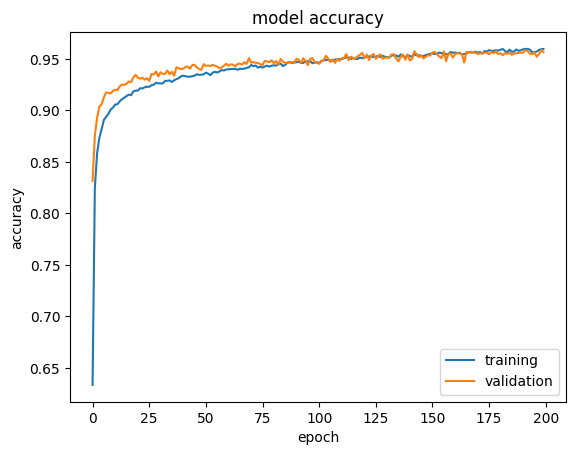

Test loss: 0.18
Test accuracy: 0.945
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]


In [ ]:
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy']) #LOSS = COST function. EVALUAR.
history = model.fit(x_train, y_train, batch_size=128, epochs=200, verbose=True, validation_split=.1) #fit = OPTIMIZAR.
loss, accuracy  = model.evaluate(x_test, y_test, verbose=False) #evalua en la última época, no necesariamente la mejor. Ver checkpoints y monitors.
mypredictions  = model.predict(x_test)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')
print(f'Shape of my predictions (test set): {mypredictions.shape}')
yidx = np.argmax(y_test, axis=1) #from one hot encoding to integers
mypidx = mypredictions[1,:]
np.set_printoptions(precision=3, suppress=True)
print(f'First prediction for number {yidx[1]}, probabilities: {mypidx}')

## Algunas Ayudas

Hay un par de cosas que haremos repetidamente en este notebook:

* Construir un modelo, y
* Evaluar ese modelo.


Estas funciones nos ayudarán a comparar "manzanas con manzanas", ya que podemos estar seguros de que cuando llamamos a `create_dense` y `evaluate` nuestros modelos y régimen de entrenamiento utilizarán los mismos **hiperparámetros**. Ambos usan algunas de las variables declaradas anteriormente y, por lo tanto, ambos están explícitamente destinados a trabajar con el conjunto de datos MNIST.

`create_dense` acepta una matriz del tamaños de la  capa y devuelve un modelo Keras de una red neuronal completamente conectada con los tamaños de capa especificados. Por ejemplo, `create_dense ([32, 64, 128])` devolverá una red neuronal profundamente conectada con tres capas ocultas, la primera con 32 nodos, la segunda con 64 nodos y la tercera con 128 nodos.

`create_dense` usa la variable `image_size` declarada anteriormente, lo que significa que asume que los datos de entrada serán un vector con 784 unidades. Todas las capas ocultas usan la función de activación sigmoid, excepto la capa de salida, que usa softmax.

`evaluate` imprime un resumen del modelo, entrena el modelo y luego imprime la pérdida y la precisión. Esta función siempre ejecuta 5 épocas de entrenamiento y utiliza un *tamaño de batch* fijo de 128 entradas por *batch*. También utiliza los datos MNIST extraídos de Keras que procesamos anteriormente.



In [ ]:
from keras import regularizers
def create_dense(layer_sizes):
    model = Sequential()
    model.add(Dense(layer_sizes[0], activation='sigmoid', kernel_regularizer=regularizers.L2(1e-4), input_shape=(image_size,)))#aqui anidir kernel_regularizer

    for s in layer_sizes[1:]:
        model.add(Dense(units = s, activation = 'sigmoid',kernel_regularizer=regularizers.L2(1e-4))) #aqui aniadir kernel_regularizer

    model.add(Dense(units=num_classes, activation='softmax'))
    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    return model


def evaluate(model, batch_size=128, epochs=5, verbose=False):
    model.summary()
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy']) #accuracy = 1 - error
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=.1, verbose=verbose) #entrenando 
    loss, accuracy  = model.evaluate(x_test, y_test, verbose=False) #YA NO ENTRENA PERO EVALUA EN EL CONJ DE TEST.
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.show()

    print()
    print(f'Test loss: {loss:.3}')
    print(f'Test accuracy: {accuracy:.3}')
    print(f'Shape of my predictions (test set): {mypredictions.shape}')
    yidx = np.argmax(y_test, axis=1) #from one hot encoding to integers
    mypidx = mypredictions[1,:]
    np.set_printoptions(precision=3, suppress=True)
    print(f'First prediction for number {yidx[1]}, probabilities: {mypidx}')

# Ejemplo de uso de las funciones creadas
A continuacion se muestra un ejemplo de como usar las anteriores funciones.
El lazo `for` genera 2 iteraciones. En la primera iteración, layers = 1 y se genera un modelo con 2 capas de 32 nodos cada una. En la segunda iteración, layers = 2 y se genera un modelo con 4 capas de 32 nodos debido a que se repite dos veces la matriz [32, 32] * 2 = [32, 32, 32, 32].

Para la evaluacion del modelo se usa la funcion `evaluate` con los parametros batch_size=128 y epochs=10.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                25120     
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 10)                330       
                                                                 
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
422/422 [==============================] - 3s 4ms/step - loss: 2.2054 - accuracy: 0.3436 - val_loss: 2.0358 - val_accuracy: 0.5447
Epoch 2/10
422/422 [==============================] - 2s 4ms/step - loss: 1.9339 - accuracy: 0.5676 - val_loss: 1.8028 - val_accuracy: 0.6482
Epoch 3/10
422/422 [==========

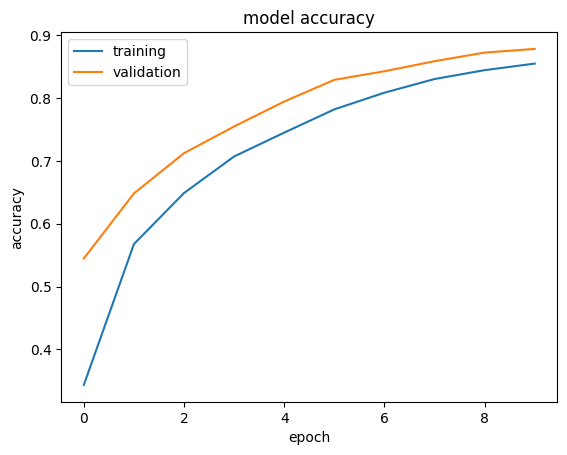


Test loss: 0.739
Test accuracy: 0.866
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 32)                25120     
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 10)                330       
                                                                 
Total params: 27,562
Trainable params: 27,562
Non-trainable params: 0
_____________________________________________________

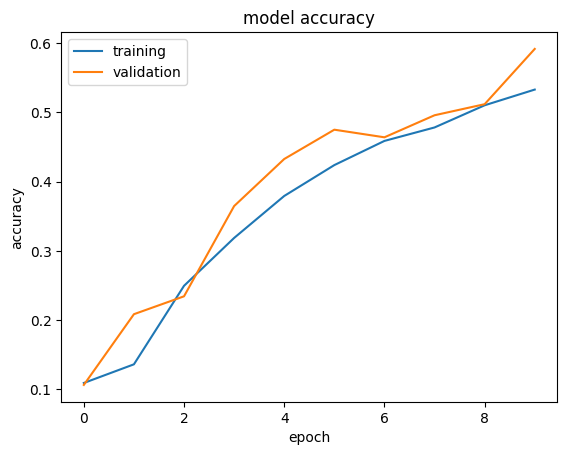


Test loss: 1.8
Test accuracy: 0.58
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 32)                25120     
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                                 
 dense_11 (Dense)            (None, 32)                1056      
                                                                 
 dense_12 (Dense)            (None, 32)                1056      
                                                                 
 dense_13 (Dense)            (None, 10)                330       
                                                            

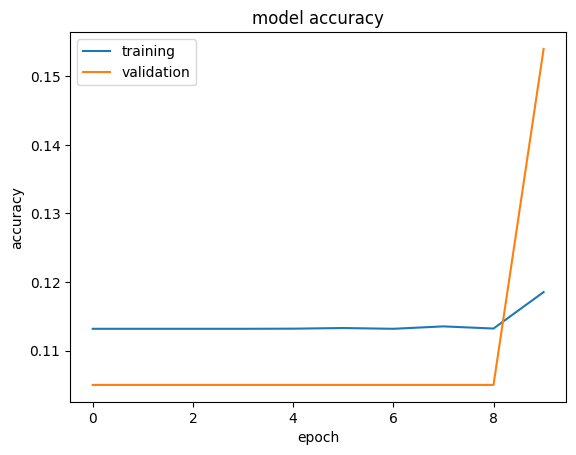


Test loss: 2.29
Test accuracy: 0.167
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]


In [ ]:
for layers in [2, 3, 4]:
    #print(i)
    model = create_dense([32] * layers)
    evaluate(model, batch_size=128, epochs=10, verbose=True) #verbose por defecto es false

#EQUIVALENTE del for
#model = create_dense([32, 32]) #2 hidden layers de 32 nodos cada una
#evaluate(model, batch_size=128, epochs=10, verbose=True)

#model = create_dense([32, 32, 32, 32]) #2 hidden layers de 32 nodos cada una
#evaluate(model, batch_size=128, epochs=10, verbose=True)


## **1. Comparar redes más complejas (4 puntos)**


*  Ahora entrene y evalúe modelos con **diferente números de capas** ocultas. Todas las capas ocultas deben tener 32 nodos. El primer modelo tiene 1 capa oculta, el segundo 2 ... hasta cuatro capas.  Analice la exactitud obtenida en cada caso.

*Evalue el modelo con los parametros por defecto*





Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 32)                25120     
                                                                 
 dense_15 (Dense)            (None, 10)                330       
                                                                 
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
422/422 [==============================] - 3s 6ms/step - loss: 1.4191 - accuracy: 0.6451 - val_loss: 0.9955 - val_accuracy: 0.8312
Epoch 2/100
422/422 [==============================] - 2s 4ms/step - loss: 0.8856 - accuracy: 0.8268 - val_loss: 0.7114 - val_accuracy: 0.8810
Epoch 3/100
422/422 [==============================] - 2s 4ms/step - loss: 0.6959 - accuracy: 0.8595 - val_loss: 0.5772 - val_accuracy: 0.8948
Epoch 4/100
422/4

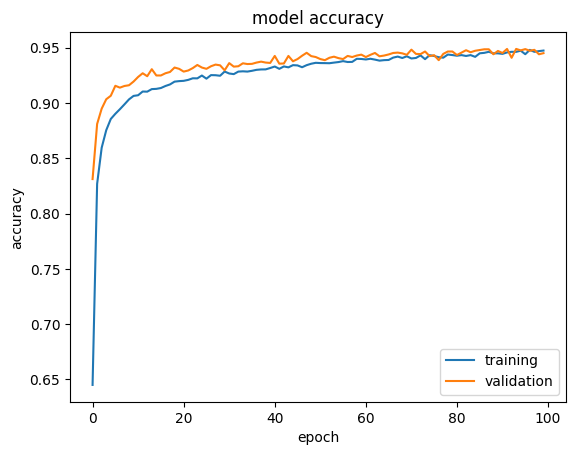


Test loss: 0.226
Test accuracy: 0.934
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 32)                25120     
                                                                 
 dense_17 (Dense)            (None, 32)                1056      
                                                                 
 dense_18 (Dense)            (None, 10)                330       
                                                                 
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
422/422 [==============================] - 3s 4ms/step - loss: 2.1564 - accuracy: 0.3809 - val_loss: 1.9952

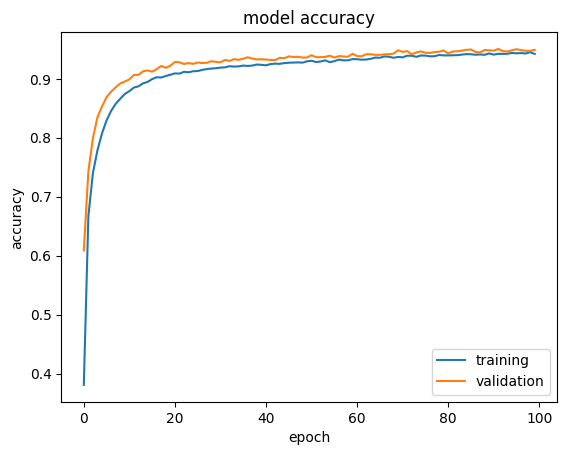


Test loss: 0.242
Test accuracy: 0.936
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 32)                25120     
                                                                 
 dense_20 (Dense)            (None, 32)                1056      
                                                                 
 dense_21 (Dense)            (None, 32)                1056      
                                                                 
 dense_22 (Dense)            (None, 10)                330       
                                                                 
Total params: 27,562
Trainable params: 27,562
Non-trainable params: 0
_____________________________________________________

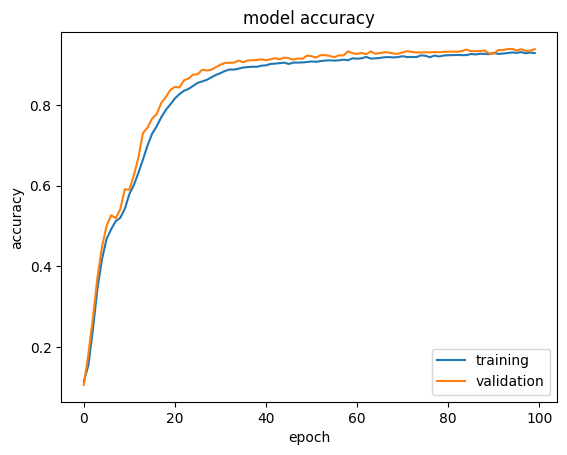


Test loss: 0.316
Test accuracy: 0.925
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 32)                25120     
                                                                 
 dense_24 (Dense)            (None, 32)                1056      
                                                                 
 dense_25 (Dense)            (None, 32)                1056      
                                                                 
 dense_26 (Dense)            (None, 32)                1056      
                                                                 
 dense_27 (Dense)            (None, 10)                330       
                                                         

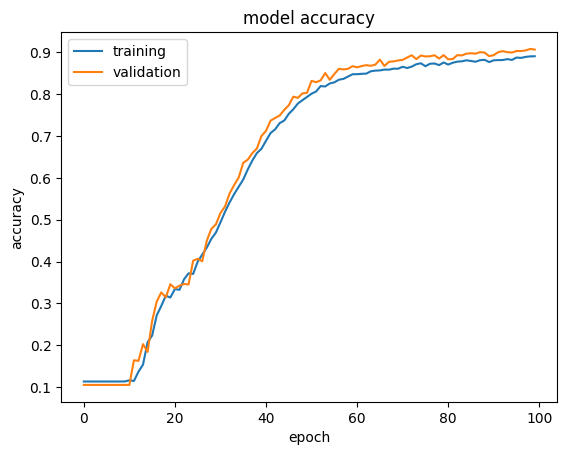


Test loss: 0.547
Test accuracy: 0.884
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]


In [ ]:
#ESCRIBA SU CÓDIGO AQUÍ.
for i in [1,2,3,4]:
  model = create_dense([32]*i) #2 hidden layers de 32 nodos cada una
  evaluate(model, batch_size=128, epochs=100, verbose=True)

## **2. Redes más profundas tardan más en entrenar (4 puntos)**

Segun lo observado en el ejemplo anterior, las redes más profundas toman más tiempo para entrenar. Esto tiene que ver con la retropropagación (backpropagation), el descenso de gradiente y la forma en que funcionan los algoritmos de optimización: esos detalles están más allá del alcance de este ejercicio.
Sin embargo, tenga en cuenta lo que sucede cuando dejamos que la red anterior de 3 capas ocultas, que tenía un rendimiento mediocre, entrene por más tiempo. Para esto, realice lo siguiente

*  Cree una red con 3 capas ocultas de 32 nodos ([32, 32, 32]) pero esta vez entrene durante 40 épocas. Qué sucedió? Comente sus resultados.

Mantenga el resto de parámetros por defecto. Puede usar la opción `verbose=True` para llamar a la función `evaluate` para ver en pantalla los resultados por época. Discuta sus resultados.


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 32)                25120     
                                                                 
 dense_29 (Dense)            (None, 32)                1056      
                                                                 
 dense_30 (Dense)            (None, 32)                1056      
                                                                 
 dense_31 (Dense)            (None, 10)                330       
                                                                 
Total params: 27,562
Trainable params: 27,562
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
422/422 [==============================] - 2s 4ms/step - loss: 2.3225 - accuracy: 0.1220 - val_loss: 2.2869 - val_accuracy: 0.1377
Epoch 2/40
422/422 [====================

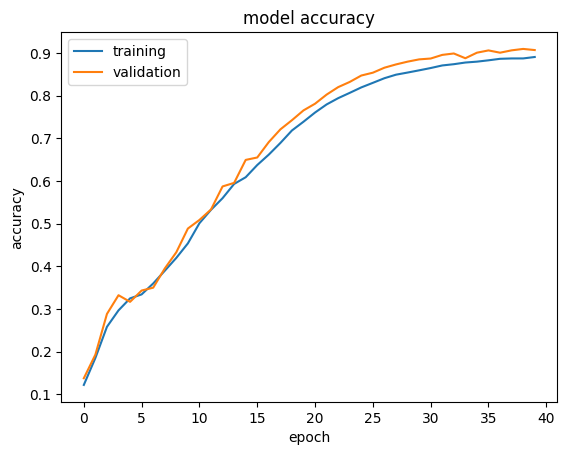


Test loss: 0.495
Test accuracy: 0.891
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]


In [ ]:
model = create_dense([32, 32, 32])
evaluate(model, batch_size=128, epochs=40, verbose=True)

En comparación al primer entrenamiento, este mejoro tanto el test loss y el test accuracy, el porcentaje de Test Loss con 10 epochs fue de 1.72 a comparación de la última que fue de 0.432, y el accuracy con 10 epochs fue de 0.547 y el nuevo fue de 0.894. Esto nos permite concluir que con las mismas condiciones con más épocas el nivel de accuracy mejora, sin embargo, hay que tomar en cuenta que se va a llegar a un punto de convergencia del modelo y no va a mejorar mucho más de ese punto así se pongan más épocas, pero en este caso si hay mejora en el entrenamiento.

### **3. Comparación del número de nodos (i.e., unidades o neuronas) por capa (4 puntos)**

Otra forma de incrementar la complejidad es agregar más nodos **(i.e., unidades o neuronas)** a cada capa oculta. Cree varias redes neuronales de una capa, con cada vez más nodos en esa capa. Pruebe con 32, 64, 128, 256, 512, 1024 y 2048 nodos. Comente sus resultados.

Note que esta vez al crear el modelo usando `create_dense`, el lazo `for` iterara sobre el numero de nodos [32, 64, 128, 256, 512, 1024, 2048]

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 32)                25120     
                                                                 
 dense_33 (Dense)            (None, 10)                330       
                                                                 
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
422/422 [==============================] - 2s 4ms/step - loss: 1.4726 - accuracy: 0.6053 - val_loss: 1.0418 - val_accuracy: 0.7940
Epoch 2/10
422/422 [==============================] - 1s 3ms/step - loss: 0.9278 - accuracy: 0.8041 - val_loss: 0.7397 - val_accuracy: 0.8675
Epoch 3/10
422/422 [==============================] - 2s 4ms/step - loss: 0.7212 - accuracy: 0.8515 - val_loss: 0.5981 - val_accuracy: 0.8880
Epoch 4/10
422/422 [

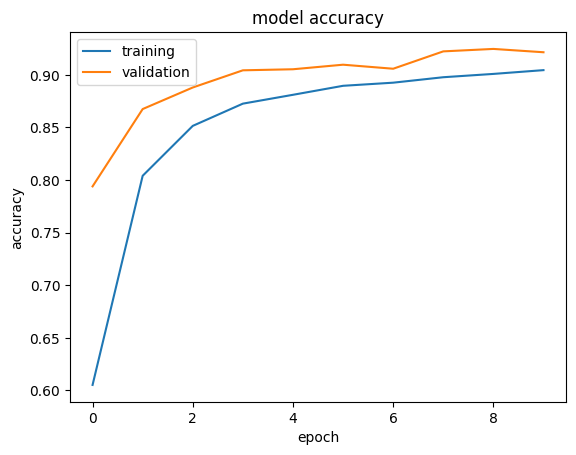


Test loss: 0.376
Test accuracy: 0.909
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 64)                50240     
                                                                 
 dense_35 (Dense)            (None, 10)                650       
                                                                 
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
422/422 [==============================] - 2s 4ms/step - loss: 1.2909 - accuracy: 0.6770 - val_loss: 0.7779 - val_accuracy: 0.8507
Epoch 2/10
422/422 [==============================] - 2s 4ms/step - loss: 0.7100 - accuracy: 0.8439 - val_lo

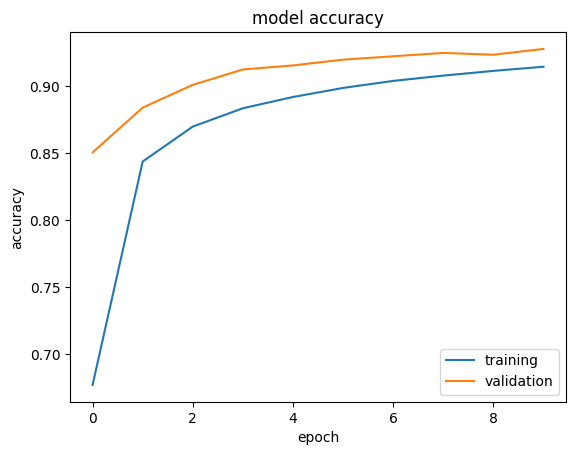


Test loss: 0.326
Test accuracy: 0.917
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 128)               100480    
                                                                 
 dense_37 (Dense)            (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
422/422 [==============================] - 2s 5ms/step - loss: 1.0461 - accuracy: 0.7377 - val_loss: 0.5839 - val_accuracy: 0.8788
Epoch 2/10
422/422 [==============================] - 2s 4ms/step - loss: 0.5653 - accuracy: 0.8672 - val_

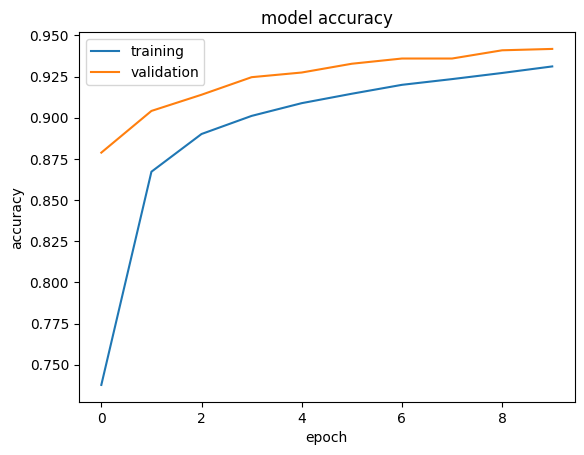


Test loss: 0.278
Test accuracy: 0.929
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 256)               200960    
                                                                 
 dense_39 (Dense)            (None, 10)                2570      
                                                                 
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
422/422 [==============================] - 4s 9ms/step - loss: 0.9214 - accuracy: 0.7792 - val_loss: 0.4926 - val_accuracy: 0.9013
Epoch 2/10
422/422 [==============================] - 3s 6ms/step - loss: 0.4871 - accuracy: 0.8875 - val_

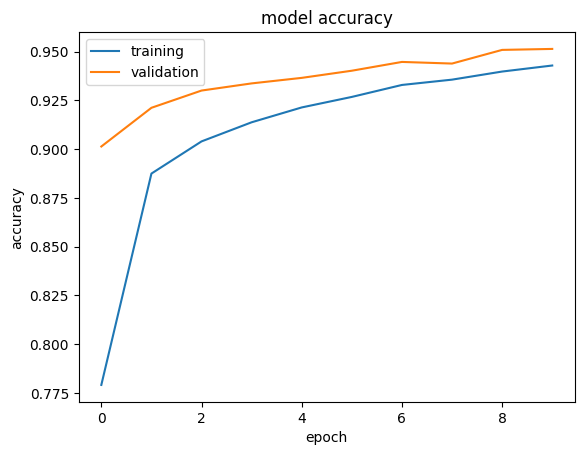


Test loss: 0.255
Test accuracy: 0.938
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 512)               401920    
                                                                 
 dense_41 (Dense)            (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
422/422 [==============================] - 5s 10ms/step - loss: 0.7971 - accuracy: 0.8087 - val_loss: 0.4324 - val_accuracy: 0.9117
Epoch 2/10
422/422 [==============================] - 5s 13ms/step - loss: 0.4365 - accuracy: 0.9016 - va

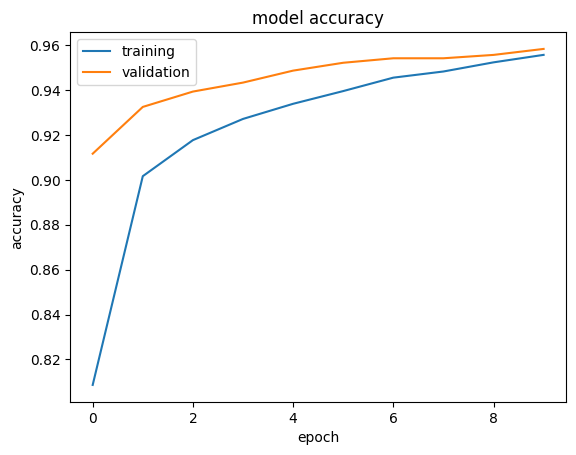


Test loss: 0.25
Test accuracy: 0.948
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 1024)              803840    
                                                                 
 dense_43 (Dense)            (None, 10)                10250     
                                                                 
Total params: 814,090
Trainable params: 814,090
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
422/422 [==============================] - 9s 19ms/step - loss: 0.6992 - accuracy: 0.8395 - val_loss: 0.3948 - val_accuracy: 0.9252
Epoch 2/10
422/422 [==============================] - 8s 19ms/step - loss: 0.4067 - accuracy: 0.9150 - val

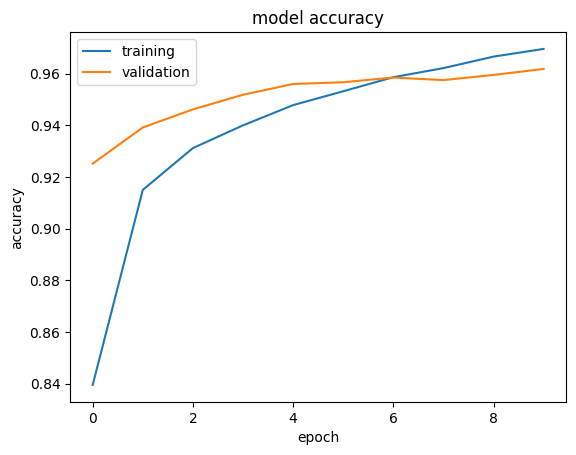


Test loss: 0.252
Test accuracy: 0.951
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 2048)              1607680   
                                                                 
 dense_45 (Dense)            (None, 10)                20490     
                                                                 
Total params: 1,628,170
Trainable params: 1,628,170
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
422/422 [==============================] - 15s 36ms/step - loss: 0.6047 - accuracy: 0.8681 - val_loss: 0.3662 - val_accuracy: 0.9325
Epoch 2/10
422/422 [==============================] - 15s 35ms/step - loss: 0.3724 - accuracy: 0.929

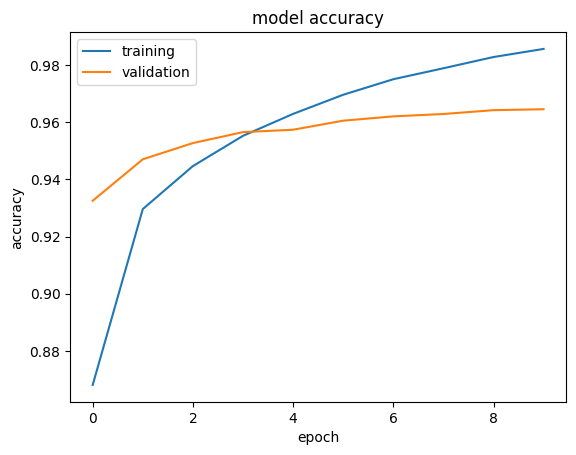


Test loss: 0.259
Test accuracy: 0.956
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]


In [ ]:
for i in [5,6,7,8,9,10,11]:
  model = create_dense([2**i])
  evaluate(model, batch_size=128, epochs=10, verbose=True)

Al igual que con la épocas, mientras más complejo la red neuronal, mejor es el entrenamiento. Se pudo observar como mejoraba el accuracy del modelo mientras en número de neuronas aumentaba, sin embargo, el tiempo que le toma al modelo acabar de entrenar aumenta con respecto al número de neuronas y esto se debe a que el número de parámetros aumenta considerablemente. También hay que tener en cuenta que, a pesar de que si hay mejora, se debe tomar en cuenta que llegará al punto de convergencia y no importa cuan complejo es el modelo, ya no mejorará el aprendizaje.

## **4. Más nodos y más capas (4 puntos)**

Ahora que hemos visto la cantidad de nodos y la cantidad de capas en un contexto aislado, veamos qué sucede cuando combinamos estos dos factores.

*   4.1 Cree un código que genere modelos con un numero de capas que se incrementan de 1 a 5. Cada capa debe tener 32 nodos. Entrene el modelo con 10 épocas por cada capa, i.e., `epochs=10*layers`. De este modo, el primero modelo tendrá 1 capa de 32 nodos y entrenará durante 10 épocas, el segundo modelo tendrá 2 capas de 32 nodos y entrenará durante 20 épocas y así sucesivamente.
*   4.2 Repita el código anterior pero esta vez cada capa tendrá 128 nodos.
*   4.3 Repita el código anterior pero esta vez cada capa tendrá 512 nodos.

Discuta sus resultados.

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 32)                25120     
                                                                 
 dense_47 (Dense)            (None, 10)                330       
                                                                 
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
422/422 [==============================] - 2s 4ms/step - loss: 1.4375 - accuracy: 0.6302 - val_loss: 1.0045 - val_accuracy: 0.8140
Epoch 2/10
422/422 [==============================] - 2s 5ms/step - loss: 0.9102 - accuracy: 0.8083 - val_loss: 0.7289 - val_accuracy: 0.8733
Epoch 3/10
422/422 [==============================] - 1s 3ms/step - loss: 0.7148 - accuracy: 0.8507 - val_loss: 0.5794 - val_accuracy: 0.8892
Epoch 4/10
422/422 

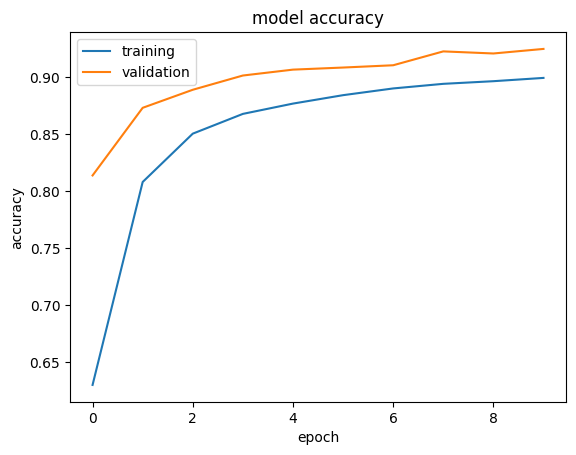


Test loss: 0.377
Test accuracy: 0.905
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 32)                25120     
                                                                 
 dense_49 (Dense)            (None, 32)                1056      
                                                                 
 dense_50 (Dense)            (None, 10)                330       
                                                                 
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
422/422 [==============================] - 2s 4ms/step - loss: 2.1484 - accuracy: 0.3890 - val_loss: 1.9826

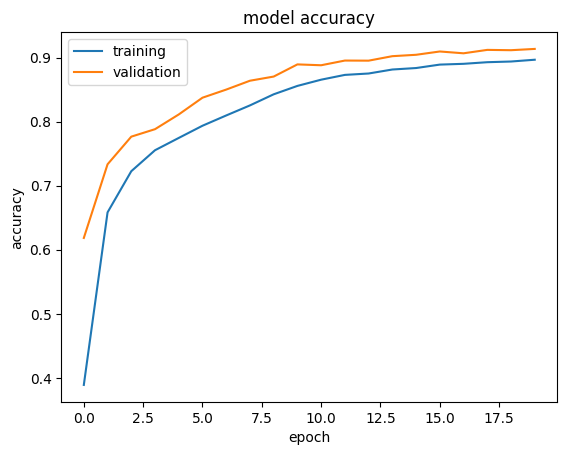


Test loss: 0.449
Test accuracy: 0.898
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 32)                25120     
                                                                 
 dense_52 (Dense)            (None, 32)                1056      
                                                                 
 dense_53 (Dense)            (None, 32)                1056      
                                                                 
 dense_54 (Dense)            (None, 10)                330       
                                                                 
Total params: 27,562
Trainable params: 27,562
Non-trainable params: 0
____________________________________________________

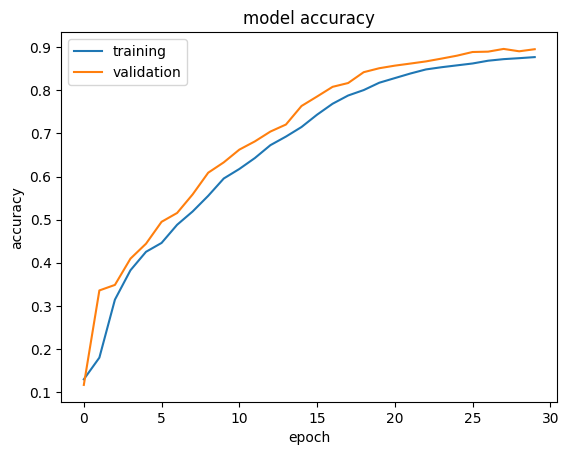


Test loss: 0.567
Test accuracy: 0.875
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_55 (Dense)            (None, 32)                25120     
                                                                 
 dense_56 (Dense)            (None, 32)                1056      
                                                                 
 dense_57 (Dense)            (None, 32)                1056      
                                                                 
 dense_58 (Dense)            (None, 32)                1056      
                                                                 
 dense_59 (Dense)            (None, 10)                330       
                                                        

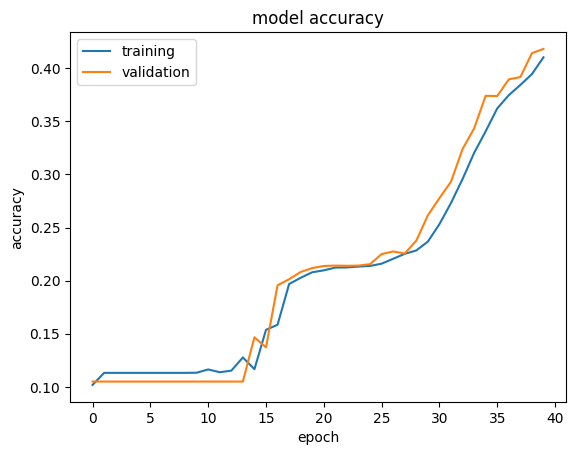


Test loss: 1.57
Test accuracy: 0.411
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 32)                25120     
                                                                 
 dense_61 (Dense)            (None, 32)                1056      
                                                                 
 dense_62 (Dense)            (None, 32)                1056      
                                                                 
 dense_63 (Dense)            (None, 32)                1056      
                                                                 
 dense_64 (Dense)            (None, 32)                1056      
                                                         

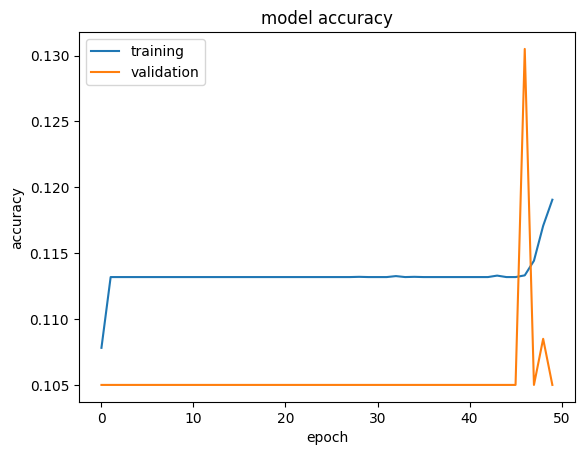


Test loss: 2.3
Test accuracy: 0.113
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]


In [ ]:
#PARTE 4.1 ESCRIBA SU CÓDIGO AQUÍ.
for i in [1,2,3,4,5]:
  model = create_dense([32]*i)
  evaluate(model, batch_size=128, epochs=10*i, verbose=True)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 128)               100480    
                                                                 
 dense_67 (Dense)            (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
422/422 [==============================] - 3s 5ms/step - loss: 1.0329 - accuracy: 0.7382 - val_loss: 0.5895 - val_accuracy: 0.8725
Epoch 2/10
422/422 [==============================] - 2s 5ms/step - loss: 0.5626 - accuracy: 0.8654 - val_loss: 0.4238 - val_accuracy: 0.9072
Epoch 3/10
422/422 [==============================] - 2s 5ms/step - loss: 0.4545 - accuracy: 0.8892 - val_loss: 0.3649 - val_accuracy: 0.9158
Epoch 4/10
422/42

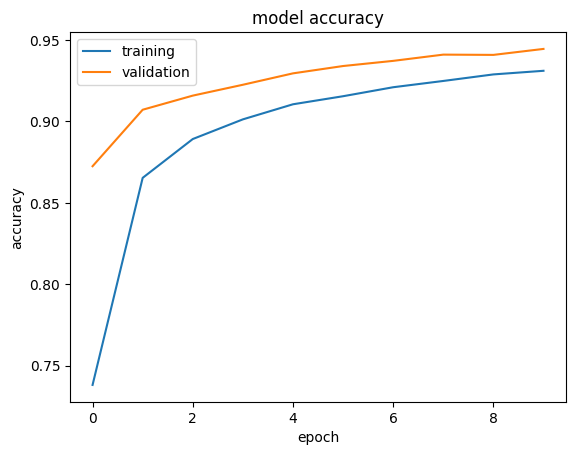


Test loss: 0.272
Test accuracy: 0.931
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 128)               100480    
                                                                 
 dense_69 (Dense)            (None, 128)               16512     
                                                                 
 dense_70 (Dense)            (None, 10)                1290      
                                                                 
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
422/422 [==============================] - 4s 8ms/step - loss: 1.9881 - accuracy: 0.5552 - val_loss: 1.65

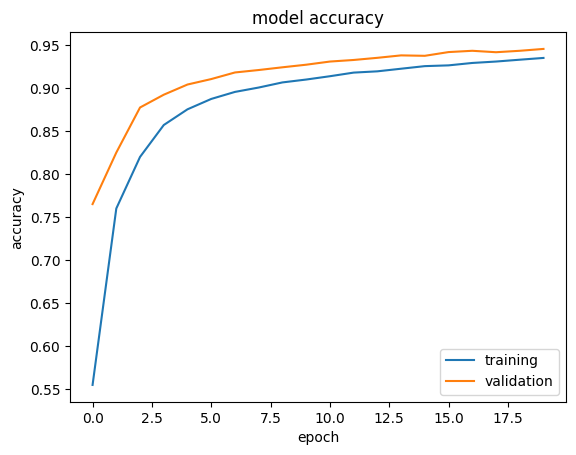


Test loss: 0.29
Test accuracy: 0.93
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_71 (Dense)            (None, 128)               100480    
                                                                 
 dense_72 (Dense)            (None, 128)               16512     
                                                                 
 dense_73 (Dense)            (None, 128)               16512     
                                                                 
 dense_74 (Dense)            (None, 10)                1290      
                                                                 
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
____________________________________________________

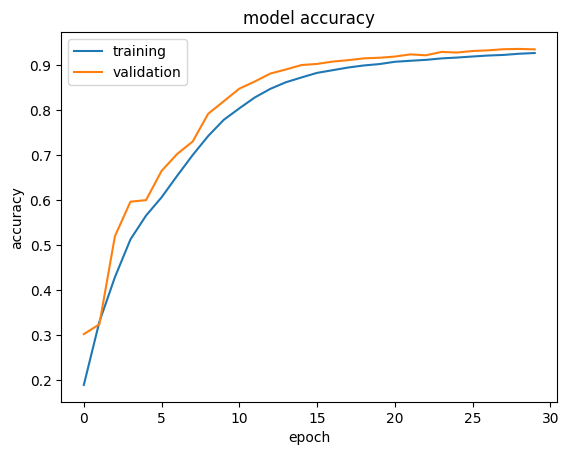


Test loss: 0.348
Test accuracy: 0.924
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_75 (Dense)            (None, 128)               100480    
                                                                 
 dense_76 (Dense)            (None, 128)               16512     
                                                                 
 dense_77 (Dense)            (None, 128)               16512     
                                                                 
 dense_78 (Dense)            (None, 128)               16512     
                                                                 
 dense_79 (Dense)            (None, 10)                1290      
                                                        

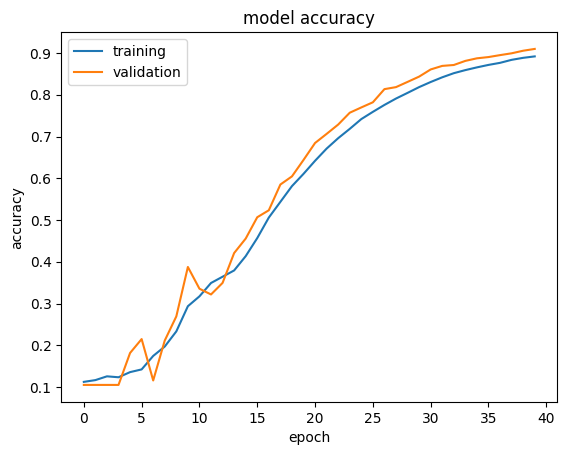


Test loss: 0.533
Test accuracy: 0.887
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_80 (Dense)            (None, 128)               100480    
                                                                 
 dense_81 (Dense)            (None, 128)               16512     
                                                                 
 dense_82 (Dense)            (None, 128)               16512     
                                                                 
 dense_83 (Dense)            (None, 128)               16512     
                                                                 
 dense_84 (Dense)            (None, 128)               16512     
                                                        

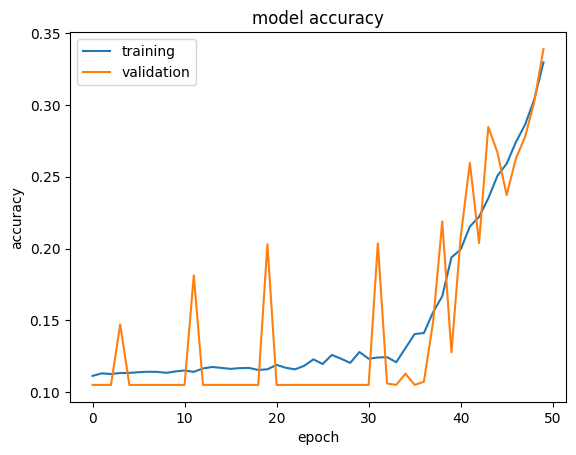


Test loss: 1.76
Test accuracy: 0.333
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]


In [ ]:
#PARTE 4.2 ESCRIBA SU CÓDIGO AQUÍ.
for i in [1,2,3,4,5]:
  model = create_dense([128]*i)
  evaluate(model, batch_size=128, epochs=10*i, verbose=True)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_86 (Dense)            (None, 512)               401920    
                                                                 
 dense_87 (Dense)            (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
422/422 [==============================] - 4s 9ms/step - loss: 0.7952 - accuracy: 0.8133 - val_loss: 0.4356 - val_accuracy: 0.9125
Epoch 2/10
422/422 [==============================] - 5s 12ms/step - loss: 0.4409 - accuracy: 0.9006 - val_loss: 0.3469 - val_accuracy: 0.9260
Epoch 3/10
422/422 [==============================] - 4s 9ms/step - loss: 0.3720 - accuracy: 0.9161 - val_loss: 0.3110 - val_accuracy: 0.9347
Epoch 4/10
422/4

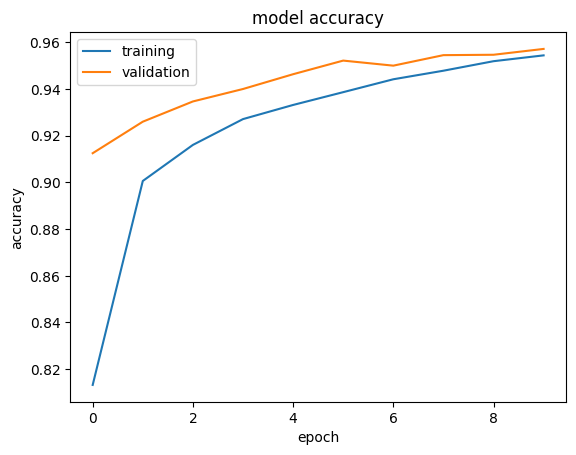


Test loss: 0.25
Test accuracy: 0.946
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_88 (Dense)            (None, 512)               401920    
                                                                 
 dense_89 (Dense)            (None, 512)               262656    
                                                                 
 dense_90 (Dense)            (None, 10)                5130      
                                                                 
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
422/422 [==============================] - 8s 18ms/step - loss: 1.7743 - accuracy: 0.6515 - val_loss: 1.20

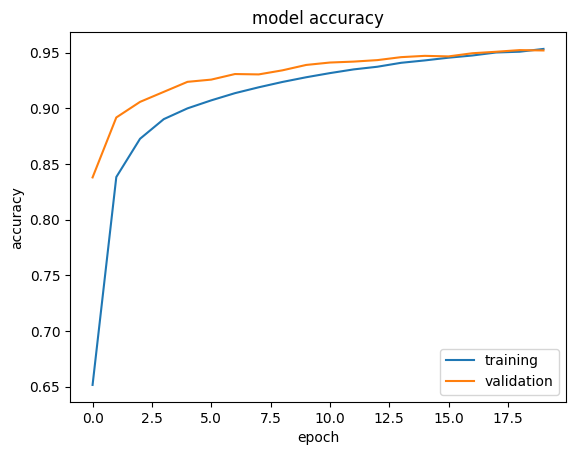


Test loss: 0.313
Test accuracy: 0.943
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_91 (Dense)            (None, 512)               401920    
                                                                 
 dense_92 (Dense)            (None, 512)               262656    
                                                                 
 dense_93 (Dense)            (None, 512)               262656    
                                                                 
 dense_94 (Dense)            (None, 10)                5130      
                                                                 
Total params: 932,362
Trainable params: 932,362
Non-trainable params: 0
__________________________________________________

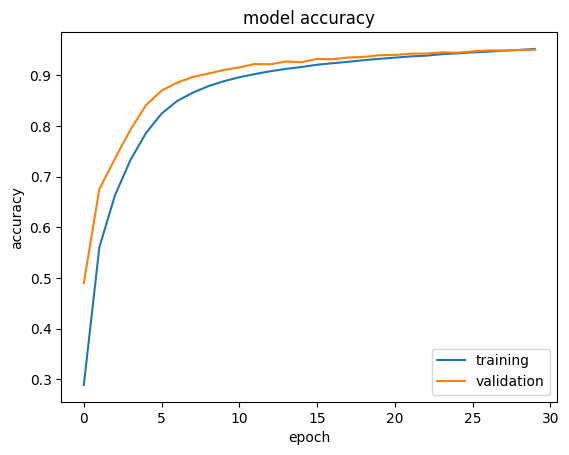


Test loss: 0.379
Test accuracy: 0.938
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_95 (Dense)            (None, 512)               401920    
                                                                 
 dense_96 (Dense)            (None, 512)               262656    
                                                                 
 dense_97 (Dense)            (None, 512)               262656    
                                                                 
 dense_98 (Dense)            (None, 512)               262656    
                                                                 
 dense_99 (Dense)            (None, 10)                5130      
                                                        

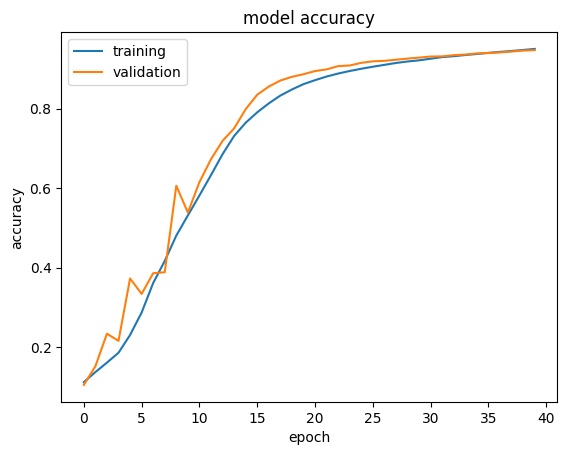


Test loss: 0.474
Test accuracy: 0.93
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_100 (Dense)           (None, 512)               401920    
                                                                 
 dense_101 (Dense)           (None, 512)               262656    
                                                                 
 dense_102 (Dense)           (None, 512)               262656    
                                                                 
 dense_103 (Dense)           (None, 512)               262656    
                                                                 
 dense_104 (Dense)           (None, 512)               262656    
                                                         

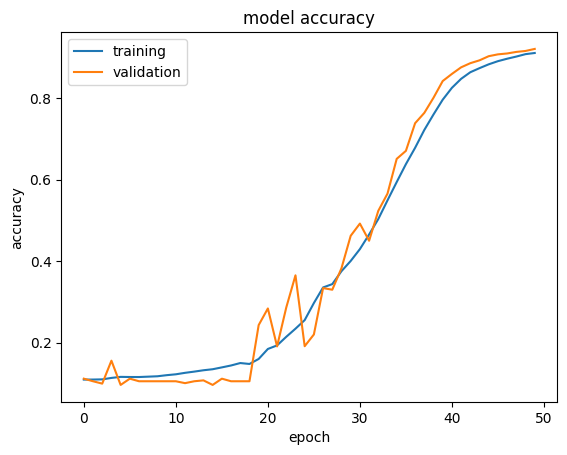


Test loss: 0.643
Test accuracy: 0.905
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]


In [ ]:
#PARTE 4.3 ESCRIBA SU CÓDIGO AQUÍ.
for i in [1,2,3,4,5]:
  model = create_dense([512]*i)
  evaluate(model, batch_size=128, epochs=10*i, verbose=True)

Es interesante ver que en cada uno de los modelos, mientras más neuronas más tiempo le toma al modelo acabar el entrenamiento. Sin embargo, algo que se debe mencionar es que en todos los modelos, el entrenamiento con más capas y más épocas se produjo un overfitting ya que el accuracy de cae en todos los modelos conforma hay más capas y épocas.

## **5. Mas capas, más entrenamiento, Batch más pequeño (4 puntos)**

A veces, los modelos con varias capas necesitan no solo entrenarse durante más tiempo, sino que también necesitan más "correcciones" por época. Al disminuir el tamaño del *batch*, podemos aumentar el número de "correcciones"  que obtiene un modelo para mejorar su desempeño. También nos aseguramos de que obtenga información más detallada ajustando el error en un *batch* más pequeño.

En este caso, podemos forzar un modelo que no aprendió bien, como el modelo de la sección anterior con 5 capas ocultas de 32 nodos, para lograr una precisión moderadamente respetable. Aunque dicho rendimiento aún no sea excelente, vale la pena mencionar que con paciencia y potencia computacional podemos hacer que un modelo que parezca malo tenga un rendimiento decente. 

Con este objetivo, Cree un modelo que tenga 5 capas de 32 nodos (i.e., similar al de la sección anterior que tuvo rendimiento pobre) y entrénelo durante 50 épocas pero esta vez con un tamaño de batch de 16 (batch_size=16).Discuta sus resultados y compare con el modelo de 5 capas ocultas de 32 nodos de la sección anterior. 

***Considere que este experimento puede demorar en ejecutar***

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_106 (Dense)           (None, 32)                25120     
                                                                 
 dense_107 (Dense)           (None, 32)                1056      
                                                                 
 dense_108 (Dense)           (None, 32)                1056      
                                                                 
 dense_109 (Dense)           (None, 32)                1056      
                                                                 
 dense_110 (Dense)           (None, 32)                1056      
                                                                 
 dense_111 (Dense)           (None, 10)                330       
                                                                 
Total params: 29,674
Trainable params: 29,674
Non-tra

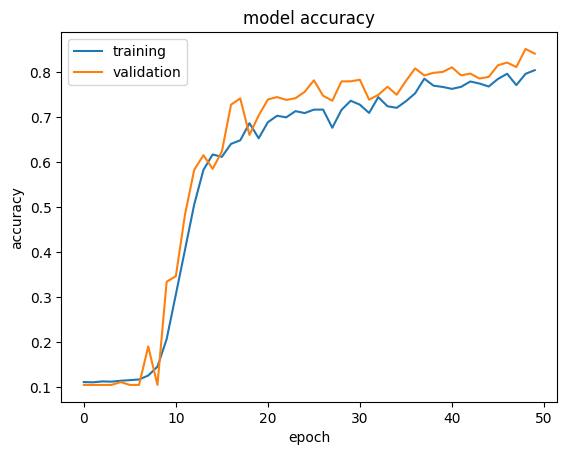


Test loss: 0.744
Test accuracy: 0.822
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]


In [ ]:
#ESCRIBA SU CÓDIGO AQUÍ.
model = create_dense([32,32,32,32,32])
evaluate(model, batch_size=16, epochs=50, verbose=True)

Se puede observar una mejora notable en el entrenamiento. Tanto el test losss como el accuracy bajaron y subieron, respectivamente. El test loss anterior era de 1.87, demasiado alto y el accuracy fue de 0.219, es decir que no reconocia nada del número. Pero con un batch size más pequeño el accuracy mejoro a 0.776 y el test loss bajo a 0.737, y aunque es aun muy bajo, es mejor que el primer resultado.

# **6. Regularización en Redes Neuronales (4 puntos)**

Como se estudió en clase, la regularización permite obtener modelos que pueden generalizar de manera más precisa en un conjunto de test.

1. Investigue cómo añadir un término de regularización igual al estudiado en clase.
2. Modifique la función `create_dense`para que todas sus capas (i.e., inclusive la capa de salida) incluyan este término de regularización. Observe que Keras requiere que se especifique en cada capa dicho término. Fije el valor del parámetro de regularización en 1e-4.
3. Repita la sección 2, 3 y 4.2 usando el término de regularización

Discuta sus resultados

Tip: al definir el modelo use el parámetro `kernel_regularizer` (variable lambda en la teoría). Ver ayuda en [aquí](https://keras.io/api/layers/regularizers/)








###Sección 2###

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_112 (Dense)           (None, 32)                25120     
                                                                 
 dense_113 (Dense)           (None, 32)                1056      
                                                                 
 dense_114 (Dense)           (None, 32)                1056      
                                                                 
 dense_115 (Dense)           (None, 10)                330       
                                                                 
Total params: 27,562
Trainable params: 27,562
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
422/422 [==============================] - 3s 4ms/step - loss: 2.3224 - accuracy: 0.1422 - val_loss: 2.2819 - val_accuracy: 0.1415
Epoch 2/40
422/422 [===================

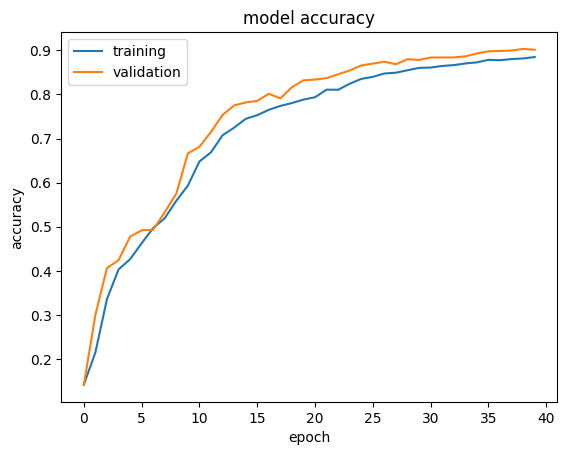


Test loss: 0.553
Test accuracy: 0.887
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]


In [ ]:
model = create_dense([32, 32, 32])
evaluate(model, batch_size=128, epochs=40, verbose=True)

###Sección 3###

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_116 (Dense)           (None, 32)                25120     
                                                                 
 dense_117 (Dense)           (None, 10)                330       
                                                                 
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
422/422 [==============================] - 2s 4ms/step - loss: 1.5276 - accuracy: 0.6109 - val_loss: 1.0389 - val_accuracy: 0.8258
Epoch 2/10
422/422 [==============================] - 1s 3ms/step - loss: 0.9354 - accuracy: 0.8209 - val_loss: 0.7420 - val_accuracy: 0.8737
Epoch 3/10
422/422 [==============================] - 1s 3ms/step - loss: 0.7277 - accuracy: 0.8558 - val_loss: 0.6094 - val_accuracy: 0.8880
Epoch 4/10
422/422 

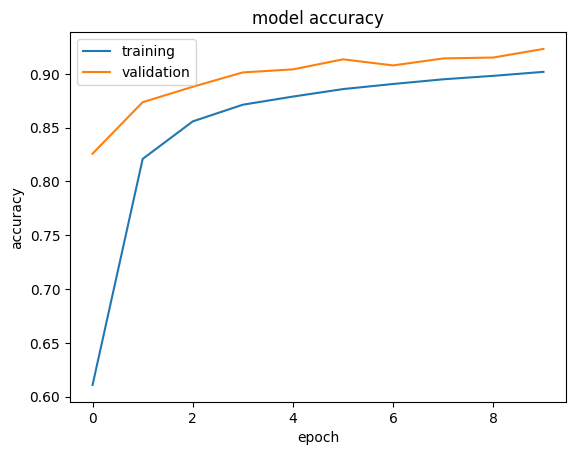


Test loss: 0.389
Test accuracy: 0.904
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_118 (Dense)           (None, 64)                50240     
                                                                 
 dense_119 (Dense)           (None, 10)                650       
                                                                 
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
422/422 [==============================] - 3s 5ms/step - loss: 1.1936 - accuracy: 0.6943 - val_loss: 0.7423 - val_accuracy: 0.8535
Epoch 2/10
422/422 [==============================] - 2s 4ms/step - loss: 0.6716 - accuracy: 0.8524 - val_lo

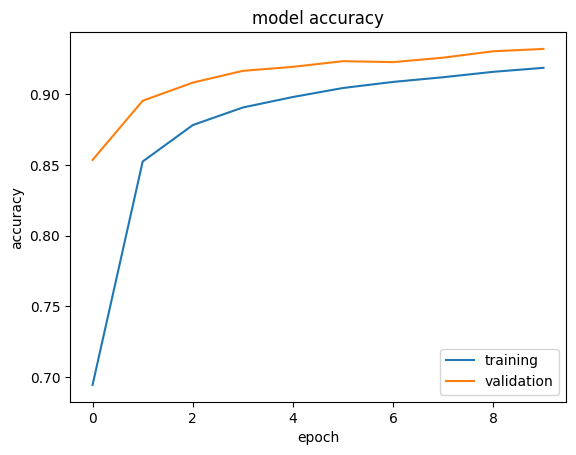


Test loss: 0.305
Test accuracy: 0.92
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_120 (Dense)           (None, 128)               100480    
                                                                 
 dense_121 (Dense)           (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
422/422 [==============================] - 2s 5ms/step - loss: 1.0705 - accuracy: 0.7326 - val_loss: 0.5744 - val_accuracy: 0.8900
Epoch 2/10
422/422 [==============================] - 2s 4ms/step - loss: 0.5544 - accuracy: 0.8732 - val_l

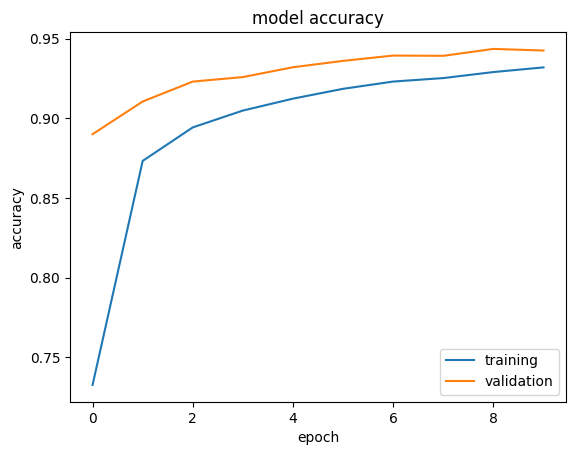


Test loss: 0.275
Test accuracy: 0.93
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_122 (Dense)           (None, 256)               200960    
                                                                 
 dense_123 (Dense)           (None, 10)                2570      
                                                                 
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
422/422 [==============================] - 3s 6ms/step - loss: 0.9077 - accuracy: 0.7747 - val_loss: 0.4794 - val_accuracy: 0.8998
Epoch 2/10
422/422 [==============================] - 3s 6ms/step - loss: 0.4847 - accuracy: 0.8858 - val_l

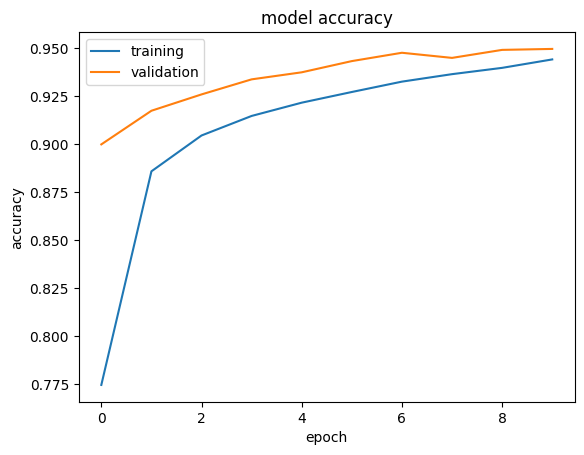


Test loss: 0.255
Test accuracy: 0.939
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_124 (Dense)           (None, 512)               401920    
                                                                 
 dense_125 (Dense)           (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
422/422 [==============================] - 5s 11ms/step - loss: 0.8273 - accuracy: 0.8027 - val_loss: 0.4430 - val_accuracy: 0.9100
Epoch 2/10
422/422 [==============================] - 4s 9ms/step - loss: 0.4456 - accuracy: 0.8998 - val

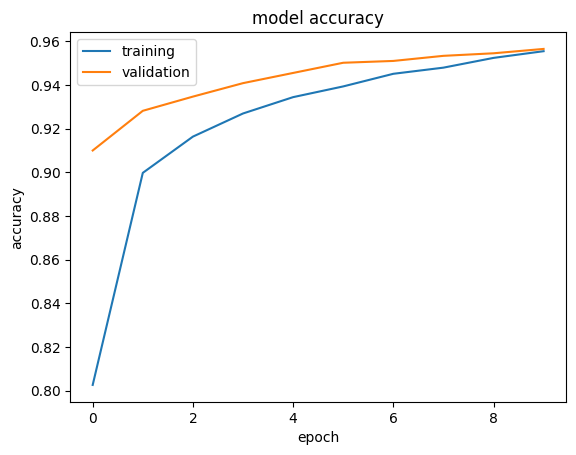


Test loss: 0.251
Test accuracy: 0.946
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_126 (Dense)           (None, 1024)              803840    
                                                                 
 dense_127 (Dense)           (None, 10)                10250     
                                                                 
Total params: 814,090
Trainable params: 814,090
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
422/422 [==============================] - 7s 17ms/step - loss: 0.7014 - accuracy: 0.8400 - val_loss: 0.3967 - val_accuracy: 0.9240
Epoch 2/10
422/422 [==============================] - 7s 17ms/step - loss: 0.4080 - accuracy: 0.9146 - va

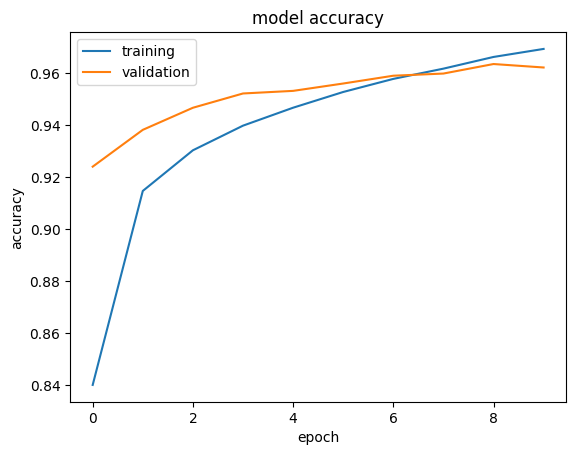


Test loss: 0.255
Test accuracy: 0.95
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_128 (Dense)           (None, 2048)              1607680   
                                                                 
 dense_129 (Dense)           (None, 10)                20490     
                                                                 
Total params: 1,628,170
Trainable params: 1,628,170
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
422/422 [==============================] - 14s 32ms/step - loss: 0.6122 - accuracy: 0.8689 - val_loss: 0.3685 - val_accuracy: 0.9333
Epoch 2/10
422/422 [==============================] - 13s 31ms/step - loss: 0.3729 - accuracy: 0.9299

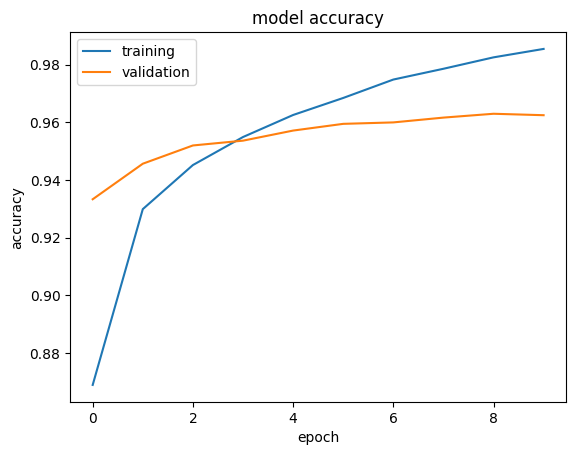


Test loss: 0.259
Test accuracy: 0.957
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]


In [ ]:
for i in [5,6,7,8,9,10,11]:
  model = create_dense([2**i])
  evaluate(model, batch_size=128, epochs=10, verbose=True)

###Sección 4.2###

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_130 (Dense)           (None, 128)               100480    
                                                                 
 dense_131 (Dense)           (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
422/422 [==============================] - 2s 4ms/step - loss: 1.0467 - accuracy: 0.7403 - val_loss: 0.5810 - val_accuracy: 0.8902
Epoch 2/10
422/422 [==============================] - 2s 4ms/step - loss: 0.5561 - accuracy: 0.8733 - val_loss: 0.4224 - val_accuracy: 0.9075
Epoch 3/10
422/422 [==============================] - 2s 4ms/step - loss: 0.4494 - accuracy: 0.8929 - val_loss: 0.3552 - val_accuracy: 0.9187
Epoch 4/10
422/42

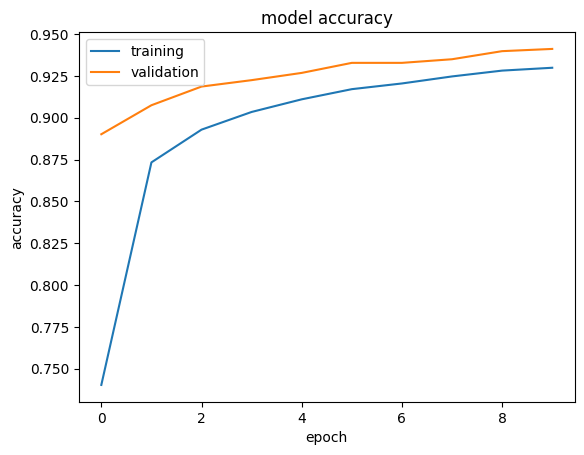


Test loss: 0.273
Test accuracy: 0.93
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_132 (Dense)           (None, 128)               100480    
                                                                 
 dense_133 (Dense)           (None, 128)               16512     
                                                                 
 dense_134 (Dense)           (None, 10)                1290      
                                                                 
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
422/422 [==============================] - 3s 5ms/step - loss: 2.0309 - accuracy: 0.5124 - val_loss: 1.708

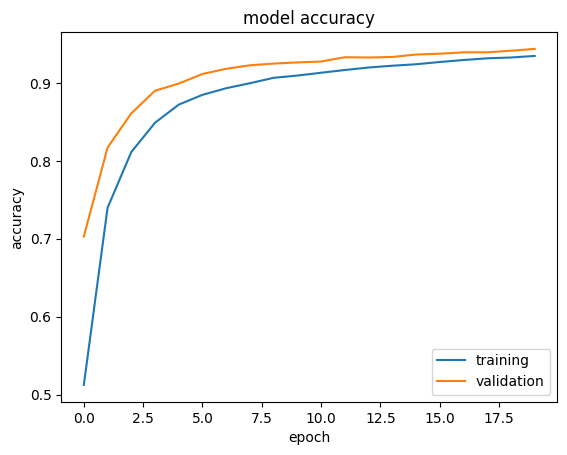


Test loss: 0.289
Test accuracy: 0.931
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_135 (Dense)           (None, 128)               100480    
                                                                 
 dense_136 (Dense)           (None, 128)               16512     
                                                                 
 dense_137 (Dense)           (None, 128)               16512     
                                                                 
 dense_138 (Dense)           (None, 10)                1290      
                                                                 
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
__________________________________________________

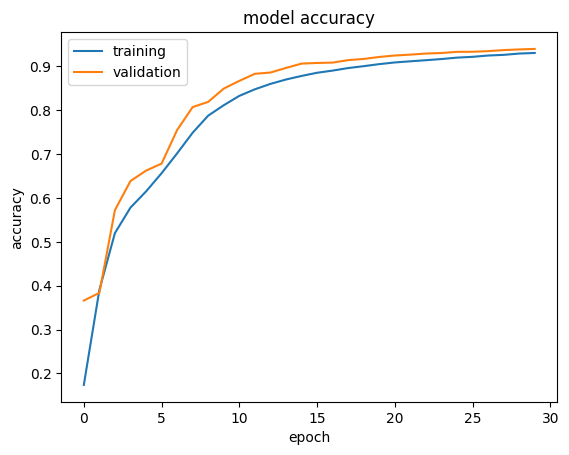


Test loss: 0.339
Test accuracy: 0.927
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_139 (Dense)           (None, 128)               100480    
                                                                 
 dense_140 (Dense)           (None, 128)               16512     
                                                                 
 dense_141 (Dense)           (None, 128)               16512     
                                                                 
 dense_142 (Dense)           (None, 128)               16512     
                                                                 
 dense_143 (Dense)           (None, 10)                1290      
                                                        

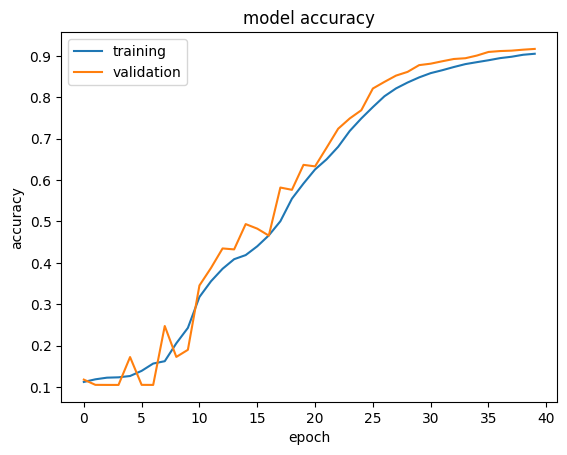


Test loss: 0.492
Test accuracy: 0.905
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_144 (Dense)           (None, 128)               100480    
                                                                 
 dense_145 (Dense)           (None, 128)               16512     
                                                                 
 dense_146 (Dense)           (None, 128)               16512     
                                                                 
 dense_147 (Dense)           (None, 128)               16512     
                                                                 
 dense_148 (Dense)           (None, 128)               16512     
                                                        

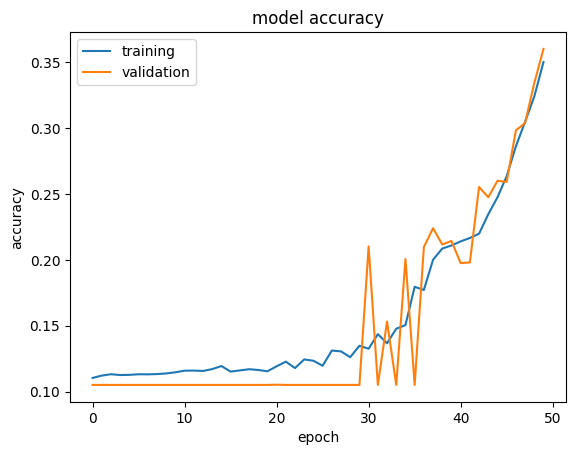


Test loss: 1.7
Test accuracy: 0.367
Shape of my predictions (test set): (10000, 10)
First prediction for number 2, probabilities: [0.001 0.001 0.977 0.003 0.    0.    0.01  0.    0.006 0.   ]


In [ ]:
for i in [1,2,3,4,5]:
  model = create_dense([128]*i)
  evaluate(model, batch_size=128, epochs=10*i, verbose=True)

En los tres casos, la regularización mejoro los modelos y en comaparación a los primeros modelos. La generalización de los modelos incrementaron el accuracy y redujeron el loss, aunque no haya sido muy grande la mejora, se puede concluir que la regularización es un factor influyente en el entramiento de modelos de redes neuronales.

# **7. Comparación (2 puntos)**

Resuma todos sus resultados en una tabla donde se verifique la precisión en el conjunto de entrenamiento, validación y test para las diferentes arquitecturas entrenadas con los hiperparámetros modificados (i.e., # de epochs, batch size, # de nodos por capa oculta, # capas ocultas, con y sin regularización).

Discuta sus resultados.

# **8. Conclusiones**
En esta sección concluya las principales observaciones de sus experimentos.



7. 
Se puede ver como con regularización, más nodos y capas y una regularización del tamaño del batch los modelos tienden a mejorar, sobre todo entre aquellos modelos que tenían un accuracy super bajo, pudieron subir ese valor. Aunque, también hubo casos en el que estos valores bajaron. Por lo que se puede concluir que se deben aplicar regularizaciones, más capas, más nodos, batch más pequeños dependiendo del modelo que se este entrenando, para que los resultados sean los mejores.

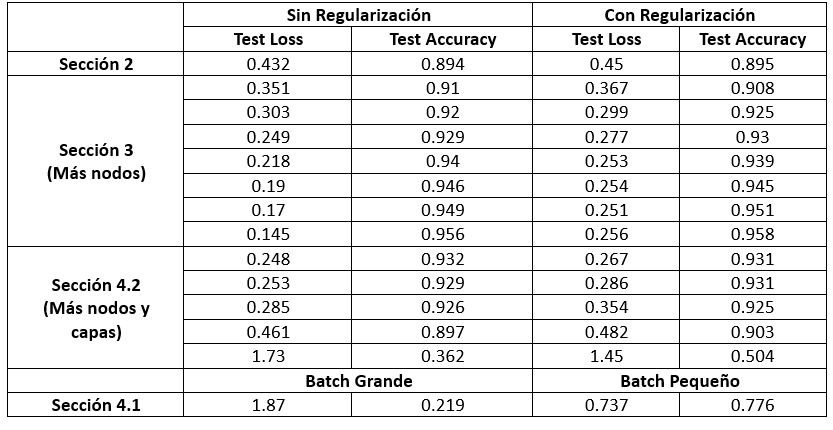




8.
- Más nodos implican un mejoramiento del modelo de entrenamiento en accuracy y loss; aunque en algunos casos la regularización en estos modelos provoca que a veces empeore el entrenamiento. 
- En caso de tener más nodos y capas no mejoraron los modelos, sino que empeorarón conforme se iba aumentando, sin embargo, con la regularización se pudo rescartar estos modelos y mejorar sus entrenamientos.
- Definir el tamaño adecuado del batch en cada epóca afecta de manera positiva a los modelos, mejorando su entrenamiento.
- Cada modelo tiene su propia naturaleza y se debe escoger la manera más apropiada para realizar su entrenamiento.

# **9. Bibliografía**
A. Lampinen, "Categorical Cross-Entropy Loss - The Most Important Loss Function," Medium, 17-Aug-2021. [Online]. Available: https://neuralthreads.medium.com/categorical-cross-entropy-loss-the-most-important-loss-function-d3792151d05b. [Accessed: 24-Mar-2023].